In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from torchvision import datasets, transforms, models

from tqdm import tqdm
import os
import PIL.Image as Image
from IPython.display import display,FileLink
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
data_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'


In [ ]:
#add transforms and load data
train_transforms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


test_transforms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,num_workers = 2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True , num_workers = 2)



In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs):
    
    losses = []
    accuracies = []
    test_accuracies = []
    use_gpu = False
    
    # Check to see whether GPU is available
    if torch.cuda.is_available():
        use_gpu = True
        model.cuda()
    else:
        model.cpu()
    print(use_gpu)
    

    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_correct = 0.0
        for i, data in tqdm(enumerate(trainloader, 0)):

            inputs, labels = data
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            
                
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, loss: %.4f, acc: %.4f" % (epoch+1,epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        
    return model, losses, accuracies, test_accuracies

    

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [ ]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 196)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
model_trained, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer,lrscheduler, n_epochs=10)

True


255it [02:33,  1.67it/s]

Epoch 1, loss: 3.9393, acc: 16.8627


Accuracy of the network on the test images: 38 %


255it [02:18,  1.84it/s]

Epoch 2, loss: 1.6107, acc: 57.6225


Accuracy of the network on the test images: 57 %


255it [02:17,  1.86it/s]

Epoch 3, loss: 0.8419, acc: 77.5000


Accuracy of the network on the test images: 60 %


255it [02:17,  1.86it/s]

Epoch 4, loss: 0.5172, acc: 85.7230


Accuracy of the network on the test images: 77 %


255it [02:16,  1.87it/s]

Epoch 5, loss: 0.3230, acc: 91.4828


Accuracy of the network on the test images: 82 %


255it [02:17,  1.85it/s]

Epoch 6, loss: 0.2196, acc: 94.2647


Accuracy of the network on the test images: 82 %


255it [02:17,  1.85it/s]

Epoch 7, loss: 0.1615, acc: 95.9191


Accuracy of the network on the test images: 84 %


255it [02:17,  1.86it/s]

Epoch 8, loss: 0.1181, acc: 96.9363


Accuracy of the network on the test images: 84 %


255it [02:16,  1.87it/s]

Epoch 9, loss: 0.0673, acc: 98.3824


Accuracy of the network on the test images: 89 %


255it [02:17,  1.85it/s]

Epoch 10, loss: 0.0430, acc: 98.9951


Accuracy of the network on the test images: 90 %


Text(0.5, 1.0, 'Test accuracy')

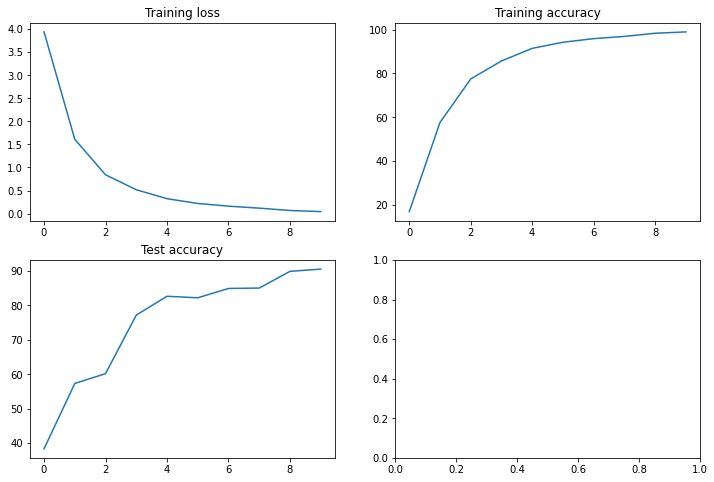

In [ ]:
f, ax = plt.subplots(2,2, figsize = (12, 8))
ax[0, 0].plot(training_losses)
ax[0, 0].set_title("Training loss")
ax[0, 1].plot(training_accs)
ax[0, 1].set_title("Training accuracy")
ax[1, 0].plot(test_accs)

ax[1, 0].set_title("Test accuracy")

In [ ]:
model.cpu()
torch.save({'arch': 'resnet34',
            'state_dict': model.state_dict(), # Holds all the weights and biases
            },
            'resnet34classifier.pth')